# Laboratorio 7
## Security Data Science
## Universidad del Valle de Guatemala

Andrés de la Roca - 20332

### Primera Parte - Creacion de la red neuronal

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.compat.v1.disable_eager_execution()

In [39]:
path = './malimg_paper_dataset_imgs/'

In [40]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [41]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [42]:
imgs, labels = next(familias)

In [43]:
imgs.shape

(9339, 64, 64, 3)

In [44]:
labels.shape

(9339, 25)

In [45]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

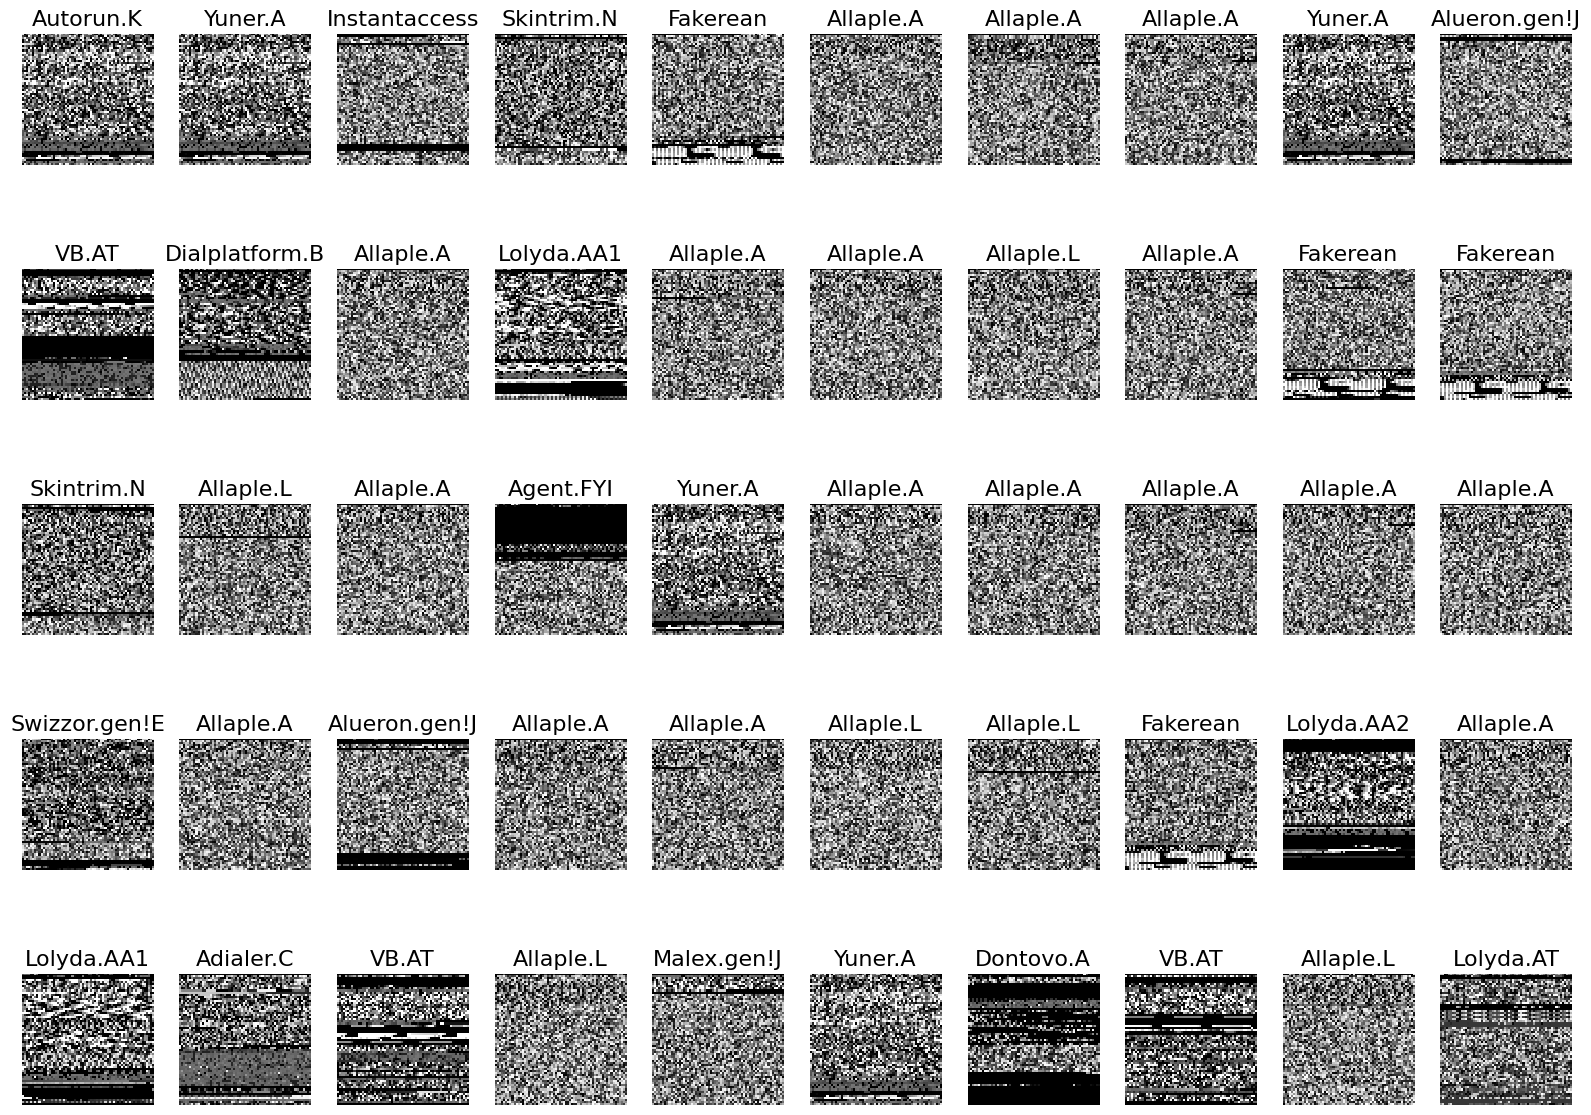

In [46]:

plots(imgs, titles = labels)

In [47]:
# 70% training, 30% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

X_train.shape

(6537, 64, 64, 3)

In [48]:
# Funciones de graficación
def plot_loss(history): # Funcion para graficar la perdida
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

def plot_accuracy(history): # Funcion para graficar la precision
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()

In [116]:
# Modelo para clasificacion de imagenes de malware
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

epochs = 5 # Numero de epocas

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(25, activation='softmax'))
# opt = Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [117]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Train on 6537 samples, validate on 2802 samples
Epoch 1/5
6537/6537 [==============================] - 23s 4ms/sample - loss: 12.8253 - accuracy: 0.5646 - val_loss: 1.1416 - val_accuracy: 0.7238
Epoch 2/5
6537/6537 [==============================] - 22s 3ms/sample - loss: 0.6424 - accuracy: 0.8141 - val_loss: 0.6104 - val_accuracy: 0.8555
Epoch 3/5
6537/6537 [==============================] - 22s 3ms/sample - loss: 0.3342 - accuracy: 0.9039 - val_loss: 0.6618 - val_accuracy: 0.8687
Epoch 4/5
6537/6537 [==============================] - 22s 3ms/sample - loss: 0.2122 - accuracy: 0.9371 - val_loss: 0.6715 - val_accuracy: 0.8822
Epoch 5/5
6537/6537 [==============================] - 22s 3ms/sample - loss: 0.1534 - accuracy: 0.9567 - val_loss: 0.7390 - val_accuracy: 0.8865


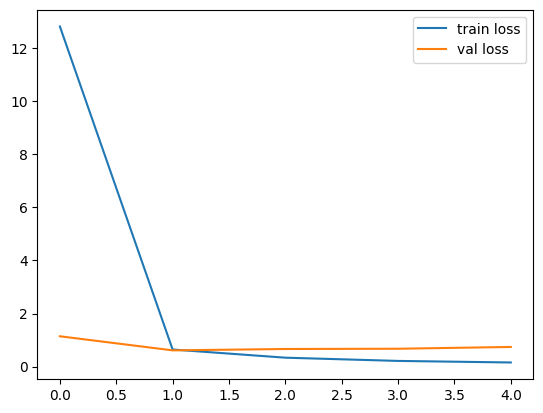

In [118]:
plot_loss(history)

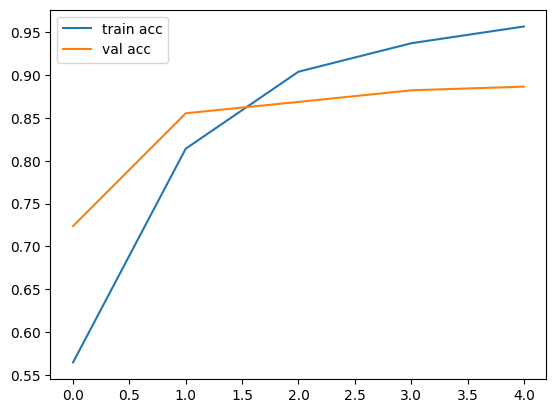

In [119]:
plot_accuracy(history)

In [120]:
results = model.evaluate(X_test, y_test)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

Loss:  0.7389607269963054
Accuracy:  0.88650966


In [121]:
# Guardar el modelo
model.save('modelo_malimg.h5')
# model.save('modelo_malimg.keras')

### Segunda Parte - Ataque a modelos

#### Ataque #1 Evasion

In [122]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

tf.compat.v1.disable_eager_execution()

In [123]:
vulnerable_model = KerasClassifier(model=model)
# vulnerable_model = tf.keras.models.load_model('modelo_malimg.h5')
model.summary()

Model: "sequential_14"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 12544)             0         
                                                                 
 dense_29 (Dense)            (None, 64)                802880    
          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


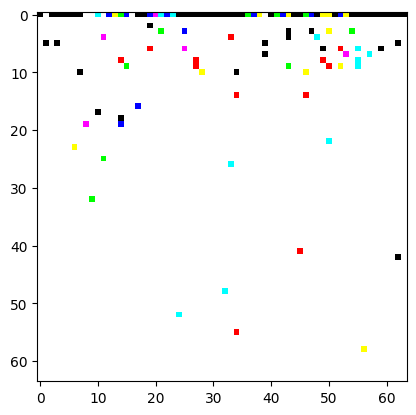

In [128]:
attack_fgsm = FastGradientMethod(estimator=vulnerable_model, eps=1)
test_images_adv = attack_fgsm.generate(X_test)
plt.imshow(test_images_adv[0])

In [129]:
# Evaluacion del modelo con ataques adversarios
results = vulnerable_model.predict(X_test)
accuracy = np.sum(np.argmax(results, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

results_adv = vulnerable_model.predict(test_images_adv)
accuracy_adv = np.sum(np.argmax(results_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on clean test examples: 88.6509635974304%
Accuracy on adversarial test examples: 56.53104925053534%


Explicacion de ataque  
Los ataques adversariales por medio del metodo de gradiente rapido son utilizadas para generar imagenes adversariales, funciona aprovechando la informacion de los gradientes del modelo con respecto a la entrada que acepta.  
Este metodo genera perturbaciones en las imagenes originales de tal manera que se logre engañar al modelo, haciendo que clasifique la imagen perturbada como una clase incorrecta.  
En el ataque realizado se puede observar que mientras mas se aumente epsilon, la imagen generara mayores perturbaciones, lo que por un lado disminuira la precision del modelo, pero por otro lado, se podra observar que la imagen perturbada se vera mas distorsionada a simple vista. En este caso se utilizo un valor de epsilon alto para ejemplificar esta perturbacion y se puede observar como la imagen perturbada esta muy distorsionada y como esto afecta la precision del modelo.

Este tipo de ataques pueden ser preocupantes porque pueden socavar la confianza en los sistemas de aprendizaje automatico, especialmente en aplicaciones criticas como la conduccion autonoma o el diagnostico medico. Ademas, revelan debilidades en la capacidad de los modelos de reconocer patrones "reales" y podrian tener implicaciones eticas y de seguridad significativas.

#### Ataque #2 MIA (Inversion)

Model inversion:   0%|          | 0/561 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

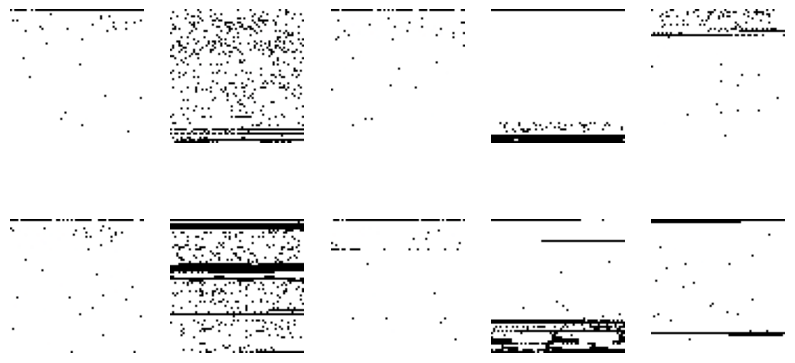

In [136]:
from art.attacks.inference.model_inversion import MIFace

attack_mi = MIFace(classifier=vulnerable_model, max_iter=2, batch_size=5)

y = np.argmax(y_test, axis=1)
test_images_inv = attack_mi.infer(X_test, y)

nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(test_images_inv[i * ncols + j])
        axes[i, j].axis('off')
plt.show()

Explicacion de ataque  
Este tipo de ataque tiene como objetivo inferir informacion sobre los datos de entrenamiento utilizados para entrenar el modelo. Estos explotan la capacidad de generalizar patrones a partir de los datos de entrenamiento, lo que puede llevar a la revelacion de informacion sensible sobre esos datos.  
Como se logra observar en la grafica, se hace una recreacion cercana a los datos de entrenamiento basicamente haciendo una inferencia segun lo que el modelo acepta como entrada, en este caso se puede observar que las imagenes generadas si se asemejan a los propuestos en el dataset de PNG's de malware. Esto puede ser especialmente peligroso si se trata de datos sensibles, como informacion medica, financiera o cualquier informacion que pueda comprometer a alguna persona involucrada.  

Estos ataques plantean preocupaciones significativas en terminos de privacidad y seguridad de los datos, ya que al revelar informacion sobre los datasets, estos ataques pueden llegar a comprometer la privacidad de una persona o de una organizacion, lo cual abre la puerta a posibles ataques de otro tipo.